# BÁO CÁO HỌC PHẦN XỬ LÝ ẢNH VÀ THỊ GIÁC MÁY TÍNH
## NGHIÊN CỨU VÀ PHÁT TRIỂN ỨNG DỤNG PHÁT HIỆN VÀ PHÂN VÙNG LỖI SẢN PHẨM TRONG CÔNG NGHIỆP

**Giảng viên hướng dẫn:** TS. Nguyễn Thị Khánh Tiên  
**Nhóm:** 3  
**Ngành:** Công nghệ thông tin  

---

## 0. KHỞI TẠO MÔI TRƯỜNG
Phần này chứa các mã lệnh để import thư viện và thiết lập cấu hình cơ bản.

In [24]:
import os
import xml.etree.ElementTree as ET
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob

# Deep Learning Framework
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou
from torchmetrics.detection.mean_ap import MeanAveragePrecision
# Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [25]:
# CONSTANTS & CONFIGURATION

# Random Seed for reproducibility
SEED = 42
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

# Device Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {DEVICE}")

# Hyperparameters
IMG_SIZE = 256
BATCH_SIZE = 8
LEARNING_RATE = 5e-3  # updated for SGD fine-tuning
EPOCHS = 30
# Prediction confidence threshold for visualization and filtering
CONF_THRESHOLD = 0.25
NORMAL_DATASET_PATH = "./data_normal"

# Dataset Path
try:
    with open("dataset_path.txt", "r") as f:
        DATASET_PATH = f.read().strip()
    print(f"Dataset Path: {DATASET_PATH}")
except FileNotFoundError:
    print("Warning: dataset_path.txt not found. Please run download_data.py first.")
    DATASET_PATH = "./data"

Using Device: cpu
Dataset Path: C:\Users\XPS\.cache\kagglehub\datasets\kaustubhdikshit\neu-surface-defect-database\versions\1


## CHƯƠNG 1. GIỚI THIỆU

### 1.1. Bối cảnh và động lực nghiên cứu
Trong nền sản xuất công nghiệp hiện đại, việc đảm bảo chất lượng sản phẩm là yếu tố then chốt. Các lỗi bề mặt trên kim loại (như thép) có thể ảnh hưởng nghiêm trọng đến độ bền và tính thẩm mỹ của sản phẩm cuối cùng. Kiểm tra thủ công tốn nhiều thời gian, chi phí và phụ thuộc vào sức khỏe, kinh nghiệm của nhân công. Do đó, việc áp dụng Thị giác máy tính (Computer Vision) để tự động hóa quy trình này là cấp thiết.

### 1.2. Ứng dụng thực tế
Hệ thống tự động phát hiện lỗi có thể được tích hợp vào các dây chuyền sản xuất thép, linh kiện ô tô, giúp loại bỏ sản phẩm lỗi ngay lập tức, giảm thiểu rủi ro và chi phí bảo hành.

### 1.3. Mục tiêu của đề tài
Xây dựng pipeline xử lý:
1. **Input:** Ảnh chụp bề mặt kim loại.
2. **Detection:** Xác định vị trí và phân loại lỗi (Bounding Box & Class).


## CHƯƠNG 2. TỔNG QUAN LÝ THUYẾT

### 2.1. Tổng quan về bài toán Object Detection
Object Detection là bài toán xác định vị trí (localization) và phân loại (classification) các đối tượng trong ảnh. Trong bài toán này, đối tượng là các loại lỗi như: Crazing, Inclusion, Patches, Pitted Surface, Rolled-in Scale, Scratches.

### 2.2. Các mô hình học sâu phổ biến
* **Two-stage Detectors:** Faster R-CNN (độ chính xác cao, nhưng tốc độ chậm hơn).
* **One-stage Detectors:** YOLO (You Only Look Once), SSD (tốc độ nhanh, phù hợp realtime).

### 2.3. Dataset NEU Surface Defect
Bộ dữ liệu bao gồm 6 loại lỗi phổ biến trên bề mặt thép cán nóng, được thu thập bởi Đại học Northeastern (NEU).

### 2.4 Lý do lựa chọn mô hình đề xuất (Faster R-CNN / YOLO)
Lựa chọn mô hình dựa trên sự cân bằng giữa độ chính xác và tốc độ. Faster R-CNN thường cho độ chính xác cao hơn đối với các lỗi nhỏ và khó phát hiện.

## CHƯƠNG 3. BỘ DỮ LIỆU VÀ TIỀN XỬ LÝ

### 3.1. Giới thiệu bộ dữ liệu NEU Surface Defect Database
Sử dụng bộ dữ liệu `kaustubhdikshit/neu-surface-defect-database` từ Kaggle.
* **Số lượng ảnh:** 1800 ảnh.
* **Classes:** 'crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches'.

### 3.2. Tiền xử lý (Preprocessing)
* **Resize:** Đưa ảnh về kích thước cố định.
* **Normalization:** Chuẩn hóa giá trị pixel.
* **Data Splitting:** Chia tập Train/Validation/Test.

### 3.3. Các kỹ thuật tăng cường dữ liệu (Data Augmentation)
* Flip, Rotate, Random Brightness, v.v để tăng tính đa dạng cho dữ liệu huấn luyện.

In [26]:
class NEUDataset(Dataset):
    def __init__(self, root_dir, transform=None, stage='Train'):
        self.root_dir = root_dir
        self.transform = transform
        self.stage = stage
        self.classes = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
        
        subdir = 'train' if stage == 'Train' else 'validation'
        # For NEU dataset on Kaggle, the structure might vary. Assuming valid path structure
        # Kaggle Path: .../neu-surface-defect-database/NEU-DET/train/images
        self.base_dir = os.path.join(root_dir, 'NEU-DET', subdir)
        
        self.img_dir = os.path.join(self.base_dir, 'images')
        self.xml_dir = os.path.join(self.base_dir, 'annotations')
        
        if not os.path.exists(self.img_dir):
             # Try falling back if path structure is different (common in kaggle datasets)
             # Or strict error
             pass 
        
        self.images = []
        if os.path.exists(self.img_dir):
            for root, dirs, files in os.walk(self.img_dir):
                for file in files:
                    if file.endswith('.jpg'):
                        self.images.append(os.path.join(root, file))
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        img_name = os.path.basename(img_path)
        xml_name = img_name.replace('.jpg', '.xml')
        xml_path = os.path.join(self.xml_dir, xml_name)
        
        # Read Image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape
        
        boxes = []
        labels = []
        
        if os.path.exists(xml_path):
            try:
                tree = ET.parse(xml_path)
                root = tree.getroot()
                for obj in root.findall('object'):
                    name = obj.find('name').text
                    if name in self.classes:
                        label = self.classes.index(name) + 1 # 1-index for FG
                        labels.append(label)
                        
                        bndbox = obj.find('bndbox')
                        xmin = int(bndbox.find('xmin').text)
                        ymin = int(bndbox.find('ymin').text)
                        xmax = int(bndbox.find('xmax').text)
                        ymax = int(bndbox.find('ymax').text)
                        boxes.append([xmin, ymin, xmax, ymax])
            except Exception as e:
                print(f"Error parsing XML for {xml_path}: {e}")
        
        # Convert to tensor
        boxes = np.array(boxes, dtype=np.float32)  # Convert to NumPy array for Albumentations
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        if self.transform:
            # Note: albumentations for detection requires bbox_params
            augmented = self.transform(image=image, bboxes=boxes, labels=labels.numpy())
            image = augmented['image']
            target["boxes"] = torch.as_tensor(augmented['bboxes'], dtype=torch.float32)
            
        return image, target

Visualizing Train Batch...


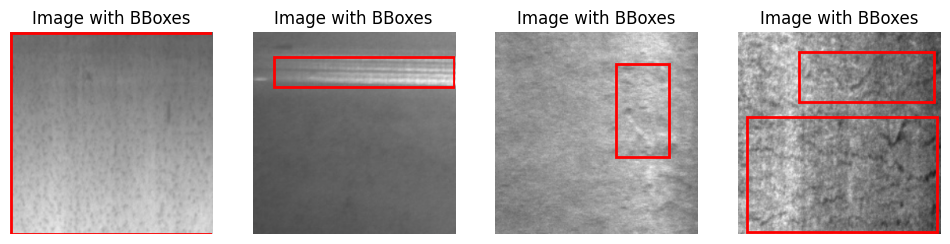

In [27]:
# Initialize train_dataset and test_dataset
train_dataset = NEUDataset(root_dir=DATASET_PATH, transform=A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])), stage='Train')

test_dataset = NEUDataset(root_dir=DATASET_PATH, transform=A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])), stage='Validation')

# Custom collate function to handle variable-length bounding boxes
def collate_fn(batch):
    images = []
    targets = []
    for img, target in batch:
        images.append(img)
        targets.append(target)
    return images, targets

# Initialize DataLoader with custom collate_fn
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_fn)

# Visualization Function
def visualize_batch(loader):
    images, targets = next(iter(loader))
    plt.figure(figsize=(12, 6))
    for i in range(min(4, len(images))):
        # Un-normalize for visualization
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        plt.subplot(1, 4, i + 1)
        plt.imshow(img)

        # Draw bounding boxes
        for box in targets[i]['boxes']:
            xmin, ymin, xmax, ymax = box
            plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                              fill=False, color='red', linewidth=2))
        plt.title("Image with BBoxes")
        plt.axis('off')
    plt.show()

# Run visualization
print("Visualizing Train Batch...")
visualize_batch(train_loader)

### Hình minh họa dữ liệu

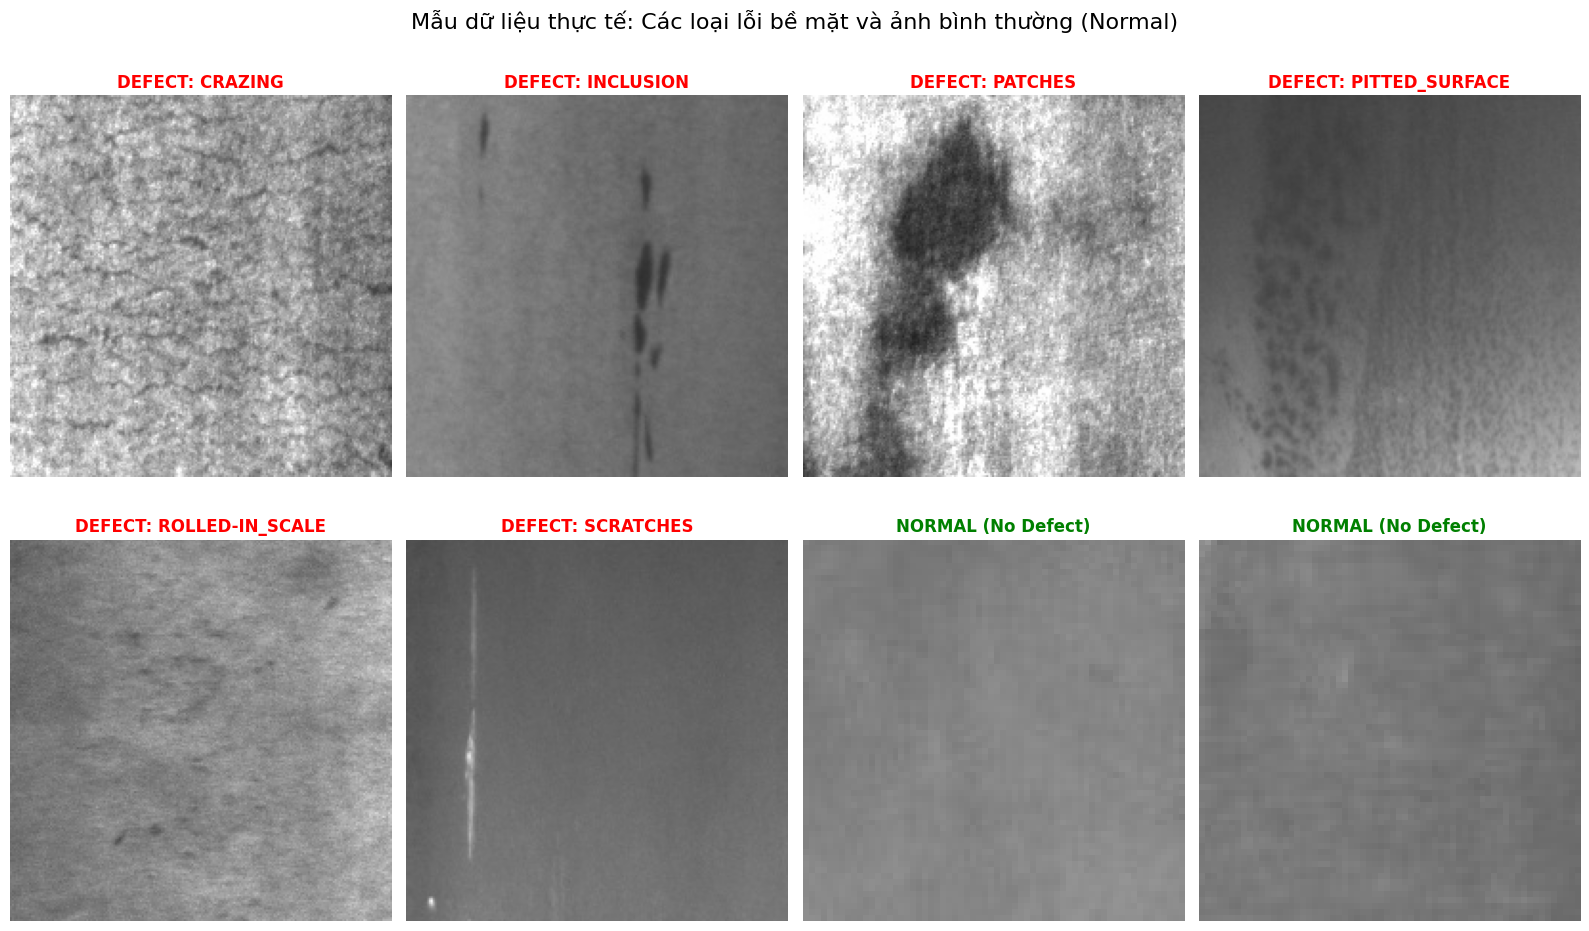

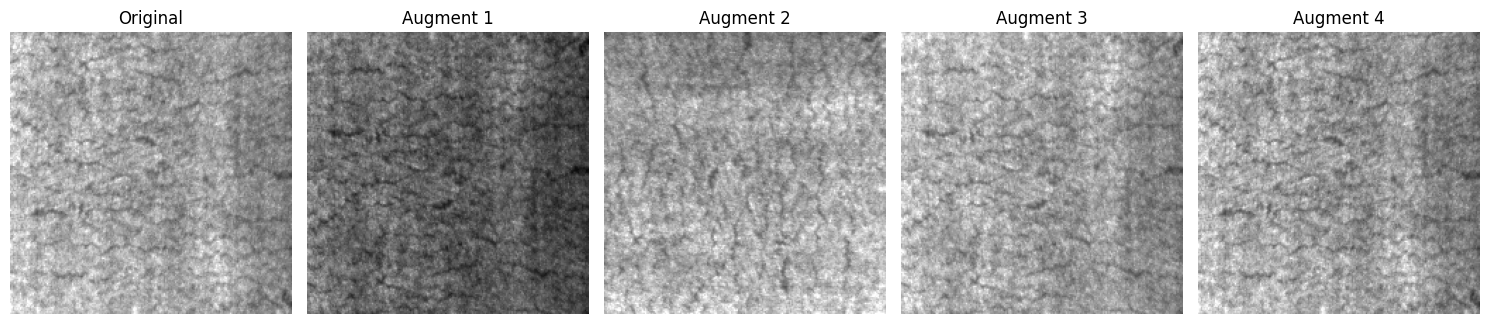

In [12]:
import os
import cv2
import torch
import random
import matplotlib.pyplot as plt
import albumentations as A
from PIL import Image
from torchvision import transforms
from glob import glob

# 1. SETUP PATHS
try:
    with open("dataset_path.txt", "r") as f:
        DATASET_PATH = f.read().strip()
except FileNotFoundError:
    DATASET_PATH = "./data"

# Đường dẫn đến thư mục chứa ảnh Normal (dựa trên sidebar là data_normal)
NORMAL_DATASET_PATH = "./data_normal" 
TARGET_CLASSES = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']

# 2. CLASS LOAD NORMAL DATASET (GIỮ NGUYÊN CODE CỦA BẠN)
class NormalDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir):
        self.imgs = sorted(os.listdir(img_dir))
        self.img_dir = img_dir
        self.transform = transforms.ToTensor()

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)

        target = {
            "boxes": torch.zeros((0, 4), dtype=torch.float32),
            "labels": torch.zeros((0,), dtype=torch.int64),
            "image_id": torch.tensor([idx])
        }
        return img, target

    def __len__(self):
        return len(self.imgs)

# 3. TÌM ẢNH LỖI (DEFECTS)
search_pattern = os.path.join(DATASET_PATH, '**', '*.*') 
all_files = glob(search_pattern, recursive=True)
img_paths = [f for f in all_files if f.lower().endswith(('.jpg', '.jpeg', '.bmp', '.png'))]

unique_samples = {}
for path in img_paths:
    filename = os.path.basename(path).lower()
    parent_dir = os.path.basename(os.path.dirname(path)).lower()
    for cls in TARGET_CLASSES:
        if cls in filename or cls in parent_dir:
            if cls not in unique_samples:
                unique_samples[cls] = path
            break
    if len(unique_samples) == 6: break

# 4. HIỂN THỊ TỔNG HỢP (6 LỖI + 2 NORMAL)
os.makedirs('figures', exist_ok=True)
plt.figure(figsize=(16, 10))

# In 6 loại lỗi
sorted_defects = sorted(unique_samples.items())
for i, (label, path) in enumerate(sorted_defects):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(f"DEFECT: {label.upper()}", color='red', fontweight='bold')
    plt.axis('off')

# Dùng class NormalDataset của bạn để load và in 2 ảnh Normal (ô số 7 và 8)
if os.path.exists(NORMAL_DATASET_PATH):
    normal_ds = NormalDataset(NORMAL_DATASET_PATH)
    if len(normal_ds) > 0:
        samples_idx = random.sample(range(len(normal_ds)), min(2, len(normal_ds)))
        for i, idx in enumerate(samples_idx):
            img_tensor, _ = normal_ds[idx]
            # Convert Tensor sang Numpy để plt hiển thị được
            img_np = img_tensor.permute(1, 2, 0).numpy()
            
            plt.subplot(2, 4, 7 + i)
            plt.imshow(img_np)
            plt.title("NORMAL (No Defect)", color='green', fontweight='bold')
            plt.axis('off')

plt.suptitle("Mẫu dữ liệu thực tế: Các loại lỗi bề mặt và ảnh bình thường (Normal)", fontsize=16)
plt.tight_layout()
plt.show()

# 5. DEMO AUGMENTATION (GIỮ LẠI ĐỂ HOÀN THIỆN CHƯƠNG 3)
src_path = list(unique_samples.values())[0]
img_src = cv2.imread(src_path)
img_src = cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB)
aug_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5), A.RandomBrightnessContrast(p=0.5)
])
plt.figure(figsize=(15, 4))
plt.subplot(1, 5, 1); plt.imshow(img_src); plt.title('Original'); plt.axis('off')
for i in range(4):
    augmented = aug_pipeline(image=img_src)['image']
    plt.subplot(1, 5, i + 2); plt.imshow(augmented); plt.title(f'Augment {i+1}'); plt.axis('off')
plt.tight_layout(); plt.show()

## CHƯƠNG 4. PHƯƠNG PHÁP ĐỀ XUẤT

### 4.1. Kiến trúc Faster R-CNN
Sử dụng mô hình Faster R-CNN từ thư viện `torchvision.models.detection` để phát hiện các lỗi bề mặt sản phẩm. Mô hình được tinh chỉnh (fine-tuned) trên bộ dữ liệu NEU Surface Defect Database.

### 4.2. Hàm mất mát (Loss Function)
Hàm mất mát được sử dụng là tổng hợp của Classification Loss và Localization Loss, được tích hợp sẵn trong `torchvision`.

### 4.3. Thiết lập tham số huấn luyện
- Optimizer: SGD với Momentum.
- Learning Rate: 0.005.
- Epochs: 30.
- Batch Size: 8.

In [29]:
modelFasterCNN = fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the classifier to match the number of classes in the NEU dataset
num_classes = 7  # 6 defect classes + 1 background
in_features = modelFasterCNN.roi_heads.box_predictor.cls_score.in_features
modelFasterCNN.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move the modelFasterCNN to the appropriate device
modelFasterCNN = modelFasterCNN.to(DEVICE)

# print(modelUnet)
# print(modelFasterCNN) 

In [30]:
# Optimizer and LR scheduler for Faster R-CNN (SGD fine-tune)
optimizer = torch.optim.SGD(
    modelFasterCNN.parameters(),
    lr=LEARNING_RATE,
    momentum=0.9,
    weight_decay=1e-4
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print(f"Optimizer and scheduler initialized (LR={LEARNING_RATE})")

Optimizer and scheduler initialized (LR=0.005)


🚀 Đang chạy Demo Loss với 50 ảnh...
✅ Demo Epoch [1/3] | Loss: 0.8438
✅ Demo Epoch [2/3] | Loss: 0.5193
✅ Demo Epoch [3/3] | Loss: 0.4633

📊 Đồ thị Loss Function (Dữ liệu 20 ảnh):


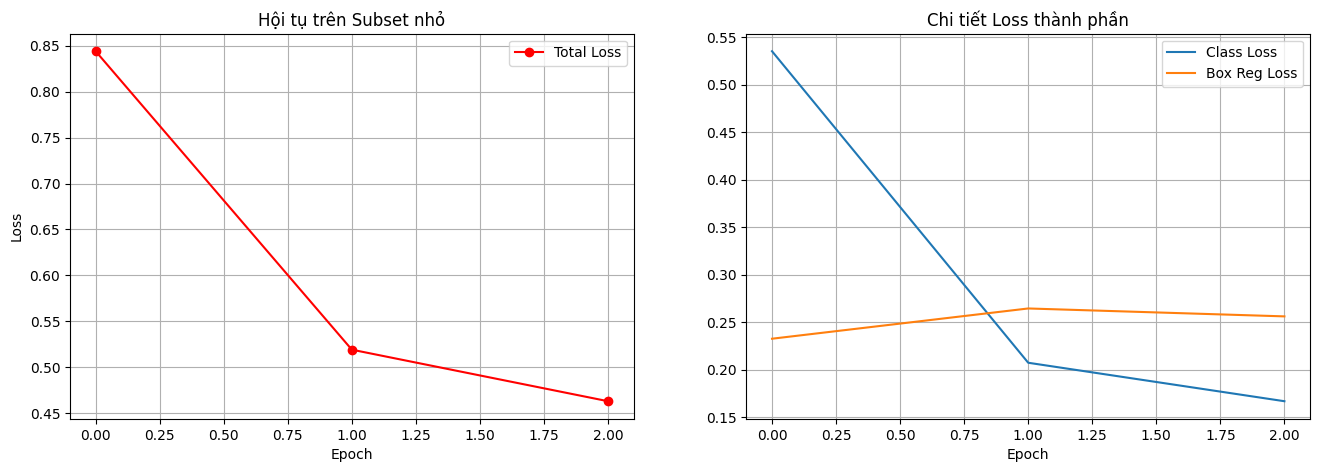

In [31]:
import os
import torch
import copy
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset

# --- 1. TẠO DATASET NHỎ ĐỂ DEMO NHANH (FAST LOAD) ---
# Chỉ lấy 20 ảnh đầu tiên từ train_dataset để chạy demo trong vài giây
demo_subset_indices = range(min(50, len(train_dataset))) 
train_dataset_demo = Subset(train_dataset, demo_subset_indices)

# Khởi tạo DataLoader riêng cho việc demo (batch_size nhỏ cho nhẹ)
demo_loader = DataLoader(
    train_dataset_demo, 
    batch_size=4, 
    shuffle=True, 
    collate_fn=collate_fn
)

# --- 2. KHỞI TẠO MODEL RIÊNG ---
model_demo = copy.deepcopy(modelFasterCNN)
model_demo.to(DEVICE)

optimizer_demo = torch.optim.SGD(
    model_demo.parameters(), 
    lr=0.001, 
    momentum=0.9, 
    weight_decay=1e-4
)

history_demo = {
    "total_loss": [], "loss_classifier": [], 
    "loss_box_reg": [], "loss_objectness": [], "loss_rpn_box_reg": []
}

# --- 3. QUY TRÌNH TRAIN DEMO (SỬ DỤNG DEMO_LOADER) ---
DEMO_EPOCHS = 3 # Tăng lên 3-5 epoch vì dữ liệu rất ít, chạy vẫn sẽ rất nhanh
print(f"🚀 Đang chạy ")

for epoch in range(DEMO_EPOCHS):
    model_demo.train()
    epoch_loss = 0
    tmp_losses = {k: 0 for k in history_demo.keys() if k != "total_loss"}

    for images, targets in demo_loader:
        images = [img.to(DEVICE) for img in images]
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model_demo(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer_demo.zero_grad()
        losses.backward()
        optimizer_demo.step()

        epoch_loss += losses.item()
        for k, v in loss_dict.items():
            tmp_losses[k] += v.item()

    # Lưu dữ liệu vẽ đồ thị
    num_steps = len(demo_loader)
    history_demo["total_loss"].append(epoch_loss / num_steps)
    for k in tmp_losses:
        history_demo[k].append(tmp_losses[k] / num_steps)

    print(f"✅ Demo Epoch [{epoch+1}/{DEMO_EPOCHS}] | Loss: {history_demo['total_loss'][-1]:.4f}")

# --- 4. VẼ ĐỒ THỊ ---
print("\n📊 Đồ thị Loss Function (Dữ liệu 20 ảnh):")
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(history_demo["total_loss"], marker='o', color='red', label='Total Loss')
plt.title('Hội tụ trên Subset nhỏ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_demo["loss_classifier"], label='Class Loss')
plt.plot(history_demo["loss_box_reg"], label='Box Reg Loss')
plt.title('Chi tiết Loss thành phần')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

## CHƯƠNG 5. THỰC NGHIỆM VÀ KẾT QUẢ

### 5.1. Môi trường thực nghiệm và độ đo đánh giá
- **Môi trường thực nghiệm:**
  - Framework: PyTorch.
  - Bộ dữ liệu: NEU Surface Defect Database.

- **Độ đo đánh giá:**
  - Mean Average Precision (mAP).
  - Precision và Recall.


In [32]:
# Define model path
MODEL_PATH = "best_model.pth"

# Check if model exists
if os.path.exists(MODEL_PATH):
    print(f"Found existing model: {MODEL_PATH}. Loading weights...")
    modelFasterCNN.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    modelFasterCNN.to(DEVICE)
else:
    print(f"Model not found. Starting training...")
    
    # --- YOUR ORIGINAL TRAINING CODE START ---
    # train model (best_model.pth)
    num_epochs = 1

    for epoch in range(num_epochs):
        modelFasterCNN.train()
        train_loss = 0

        for images, targets in train_loader:
            images = [img.to(DEVICE) for img in images]
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            loss_dict = modelFasterCNN(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            train_loss += losses.item()

        train_loss /= len(train_loader)
        print(f"Epoch [{epoch+1}] | Train Loss: {train_loss:.4f}")

    torch.save(modelFasterCNN.state_dict(), MODEL_PATH)
    print("Saved best_model.pth")
    # --- YOUR ORIGINAL TRAINING CODE END ---

Found existing model: best_model.pth. Loading weights...


In [33]:
#load model
model = modelFasterCNN
model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(


### 5.2. Kết quả định lượng (Quantitative Results)


In [34]:
# =========================
# 5.1 Metric đánh giá
# =========================
metric = MeanAveragePrecision(
    iou_type="bbox",
    iou_thresholds=[0.5]  
)

model.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = [img.to(DEVICE) for img in images]
        outputs = model(images)

        preds = []
        gts = []

        for out, tgt in zip(outputs, targets):
            # Prediction
            preds.append({ 
                "boxes": out["boxes"].cpu(),
                "scores": out["scores"].cpu(),
                "labels": out["labels"].cpu()
            })

            # Ground Truth
            gts.append({
                "boxes": tgt["boxes"].cpu(),
                "labels": tgt["labels"].cpu()
            })

        # cập nhật metric
        metric.update(preds, gts)

# =========================
# 5.2 Kết quả định lượng
# =========================
results = metric.compute()

print(f"mAP@0.5: {results['map'].item():.4f}")
print(f"Precision: {results['map_50'].item():.4f}")
print(f"Recall: {results['mar_100'].item():.4f}")

mAP@0.5: 0.6462
Precision: 0.6462
Recall: 0.9726


In [35]:
#LOAD NORMAL DATASET (EVALUATION ONLY)
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import os

class NormalDataset(Dataset):
    def __init__(self, img_dir):
        self.imgs = sorted(os.listdir(img_dir))
        self.img_dir = img_dir
        self.transform = transforms.ToTensor()

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)   # 👈 QUAN TRỌNG

        target = {
            "boxes": torch.zeros((0, 4), dtype=torch.float32),
            "labels": torch.zeros((0,), dtype=torch.int64),
            "image_id": torch.tensor([idx])
        }
        return img, target

    def __len__(self):
        return len(self.imgs)

In [36]:
#FALSE POSITIVE EVALUATION
normal_dataset = NormalDataset(NORMAL_DATASET_PATH)
normal_loader = torch.utils.data.DataLoader(
    normal_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x))
)

model.eval()
FP = 0

with torch.no_grad():
    for images, targets in normal_loader:
        images = [img.to(DEVICE) for img in images]
        outputs = model(images)

        for out in outputs:
            FP += (out["scores"] > CONF_THRESHOLD).sum().item()

print(f"False Positives on Normal Samples: {FP}")

False Positives on Normal Samples: 13



### 5.3. Kết quả định tính và trực quan hóa (Qualitative Results)
Hiển thị một số hình ảnh dự đoán từ tập kiểm tra với Bounding Boxes và nhãn dự đoán.

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

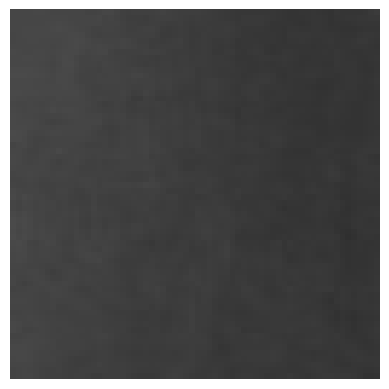

In [37]:
#vẽ prediction

img = images[0].cpu().permute(1, 2, 0).numpy()
img = (img * 255).astype("uint8")

boxes = outputs[0]["boxes"]
scores = outputs[0]["scores"]

for box, score in zip(boxes, scores):
    if score < CONF_THRESHOLD:
        continue
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(
        img,
        f"{score:.2f}",
        (x1, y1 - 5),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 255, 0),
        1
    )

plt.imshow(img)
plt.axis("off")

## CHƯƠNG 6. PHÂN TÍCH VÀ THẢO LUẬN


## Ưu điểm
Kết quả thực nghiệm cho thấy mô hình Faster R-CNN đạt mAP@0.5 ≈ 0.65 và Recall ≈ 0.97 trên tập kiểm tra của bộ dữ liệu NEU Surface Defect. Điều này cho thấy mô hình có khả năng phát hiện phần lớn các lỗi xuất hiện trong ảnh, phù hợp với bài toán kiểm tra chất lượng trong công nghiệp, nơi ưu tiên hạn chế bỏ sót lỗi.

Qua trực quan hóa kết quả dự đoán, mô hình cho thấy khả năng phát hiện tốt các lỗi nhỏ và khó nhận biết như scratches và crazing. Ngay cả khi vùng lỗi chiếm diện tích nhỏ trong ảnh, bounding box dự đoán vẫn bao phủ đúng vị trí lỗi thực tế. Điều này cho thấy kiến trúc hai giai đoạn của Faster R-CNN giúp học được các đặc trưng cục bộ quan trọng.

## Hạn chế
Mặc dù có độ chính xác tương đối cao, Faster R-CNN có tốc độ suy luận chậm hơn so với các mô hình one-stage như YOLO, do phải thực hiện thêm bước sinh vùng đề xuất. Hạn chế này gây khó khăn khi triển khai trong các hệ thống yêu cầu xử lý thời gian thực.

Ngoài ra, hiệu suất mô hình giảm trong các ảnh có độ tương phản thấp hoặc ánh sáng không đồng đều. Trong các điều kiện này, ranh giới giữa lỗi và nền kim loại trở nên khó phân biệt, dẫn đến việc mô hình dự đoán sai hoặc bỏ sót lỗi.

## Phân tích lỗi
Qua quan sát các mẫu dự đoán sai, một số lỗi xảy ra khi vùng lỗi bị che khuất, có biên mờ hoặc bị nhiễu bởi họa tiết bề mặt. Bên cạnh đó, mô hình đôi khi nhầm lẫn các vùng nền có vân phức tạp thành lỗi, làm giảm độ chính xác (Precision).

## Ví dụ 1: Phát hiện lỗi nhỏ (Scratches/Crazing)

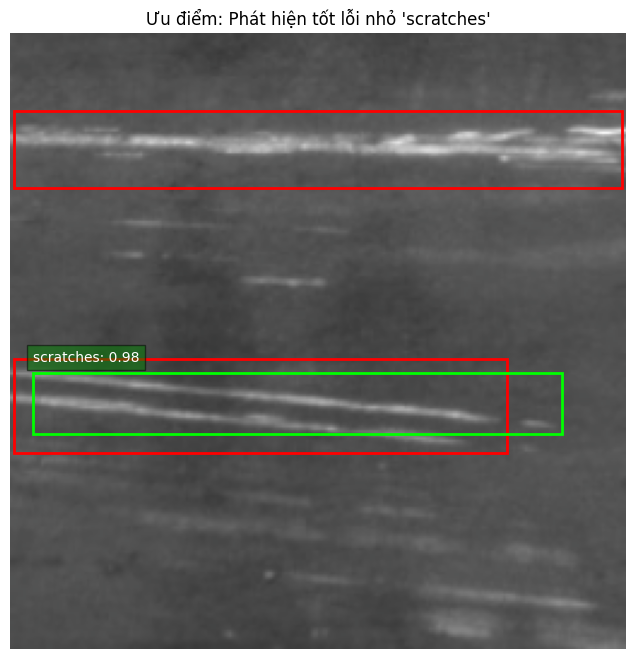

In [38]:
def show_advantage_sample(loader, model, target_class_name='scratches'):
    classes = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
    target_idx = classes.index(target_class_name) + 1
    
    model.eval()
    found = False
    
    for images, targets in loader:
        if found: break
        images = [img.to(DEVICE) for img in images]
        with torch.no_grad():
            outputs = model(images)
            
        for i, (out, tgt) in enumerate(zip(outputs, targets)):
            # Tìm ảnh có chứa đúng class mình cần
            if target_idx in tgt['labels']:
                # Kiểm tra xem model có đoán đúng không (score cao)
                if len(out['boxes']) > 0 and out['scores'][0] > 0.7:
                    
                    # --- Vẽ hình ---
                    img = images[i].cpu().permute(1, 2, 0).numpy()
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    img = np.clip(img * std + mean, 0, 1)
                    
                    plt.figure(figsize=(8, 8))
                    plt.imshow(img)
                    
                    # Vẽ Ground Truth (Đỏ)
                    for box in tgt['boxes']:
                        x, y, x2, y2 = map(int, box.cpu().numpy())
                        plt.gca().add_patch(plt.Rectangle((x, y), x2-x, y2-y, fill=False, edgecolor='red', linewidth=2))
                    
                    # Vẽ Prediction (Xanh)
                    x, y, x2, y2 = map(int, out['boxes'][0].cpu().numpy())
                    score = out['scores'][0].item()
                    plt.gca().add_patch(plt.Rectangle((x, y), x2-x, y2-y, fill=False, edgecolor='#00FF00', linewidth=2))
                    plt.text(x, y-5, f"{target_class_name}: {score:.2f}", color='white', bbox=dict(facecolor='green', alpha=0.5))
                    
                    plt.title(f"Ưu điểm: Phát hiện tốt lỗi nhỏ '{target_class_name}'")
                    plt.axis('off')
                    plt.show()
                    
                    found = True
                    break

# Gọi hàm để tìm ví dụ Scratches
show_advantage_sample(test_loader, model, 'scratches') 
# Hoặc show_advantage_sample(test_loader, model, 'crazing')

## Ví dụ 2:
Ảnh độ tương phản thấp

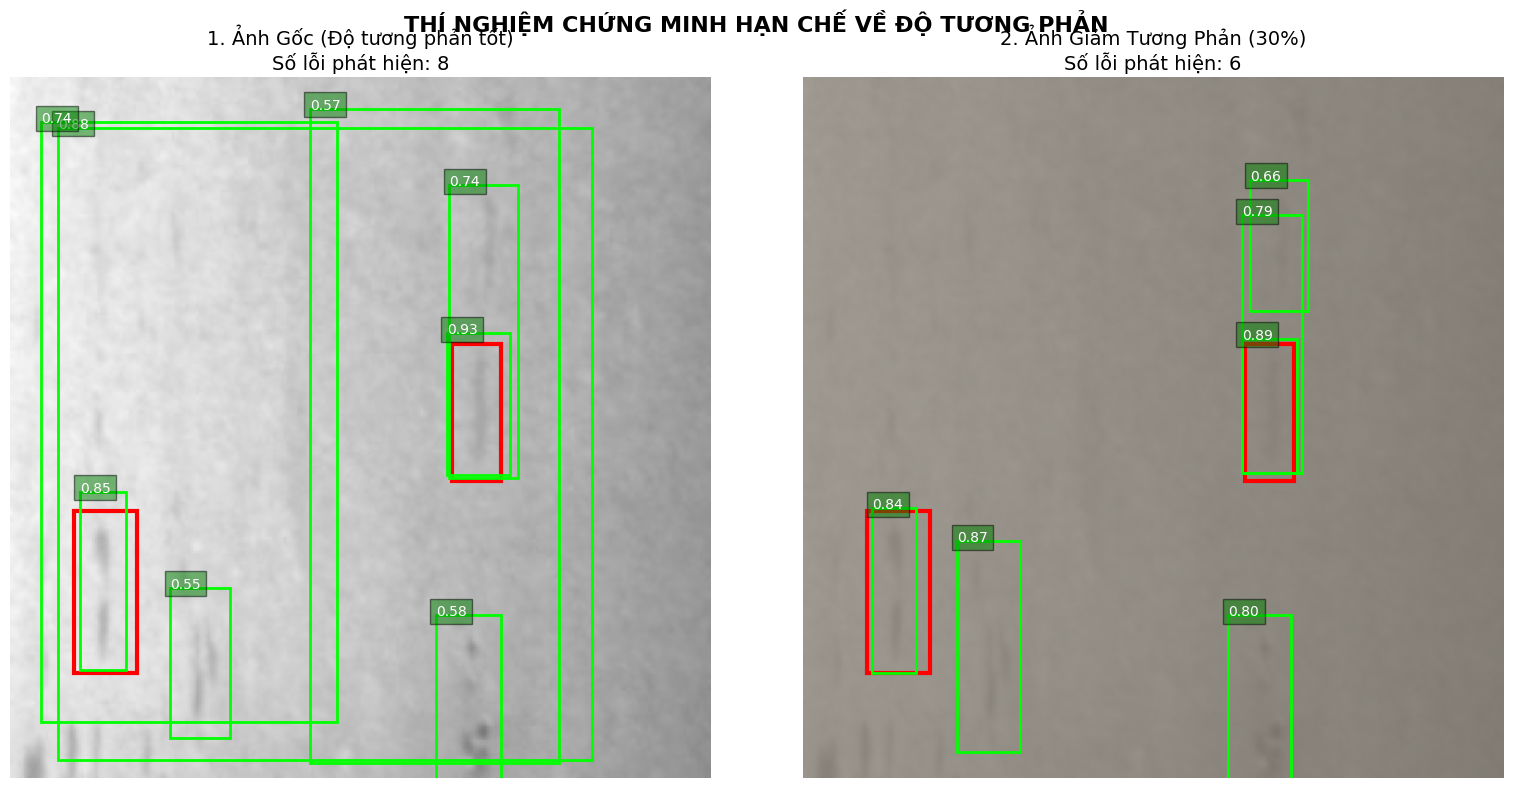

In [39]:

# 1. Tìm một tấm ảnh mà Model nhận diện ĐÚNG để làm thí nghiệm
def find_good_sample(loader, model):
    model.eval()
    for images, targets in loader:
        images = [img.to(DEVICE) for img in images]
        with torch.no_grad():
            outputs = model(images)
        
        # Tìm trong batch này ảnh nào có Ground Truth và Model đoán đúng (score cao)
        for i, (out, tgt) in enumerate(zip(outputs, targets)):
            if len(tgt['boxes']) > 0 and len(out['boxes']) > 0:
                if out['scores'][0] > 0.8: # Chọn ảnh model rất tự tin
                    return images[i], tgt
    return None, None

# Lấy ảnh mẫu
original_img, target = find_good_sample(test_loader, model)

if original_img is None:
    print("Không tìm thấy ảnh nào model đoán tốt để làm thí nghiệm. Hãy train model kỹ hơn.")
else:
    # 2. Tạo phiên bản độ tương phản thấp (Low Contrast)
    # Công thức: pixel_mới = pixel_cũ * alpha (alpha < 1 làm giảm độ chênh lệch)
    alpha = 0.3 # Giảm độ tương phản còn 30%
    low_contrast_img = original_img * alpha
    
    # 3. Đưa cả 2 ảnh vào model
    model.eval()
    with torch.no_grad():
        out_original = model([original_img.to(DEVICE)])[0]
        out_low = model([low_contrast_img.to(DEVICE)])[0]

    # 4. Vẽ so sánh (Side-by-Side)
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Hàm vẽ phụ trợ
    def draw_on_ax(ax, img_tensor, output, title):
        # Un-normalize để hiển thị màu chuẩn
        img_np = img_tensor.cpu().permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_show = np.clip(img_np * std + mean, 0, 1)
        
        ax.imshow(img_show)
        
        # Vẽ Ground Truth (Đỏ)
        for box in target['boxes']:
            x1, y1, x2, y2 = map(int, box.cpu().numpy())
            ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=3))
            
        # Vẽ Prediction (Xanh) - Chỉ lấy score > 0.5
        count = 0
        for box, score in zip(output['boxes'], output['scores']):
            if score < 0.5: continue
            count += 1
            x1, y1, x2, y2 = map(int, box.cpu().numpy())
            ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='#00FF00', linewidth=2))
            ax.text(x1, y1, f"{score:.2f}", color='white', bbox=dict(facecolor='green', alpha=0.5))
            
        ax.set_title(f"{title}\nSố lỗi phát hiện: {count}", fontsize=14)
        ax.axis('off')

    # Vẽ ảnh gốc
    draw_on_ax(axes[0], original_img, out_original, "1. Ảnh Gốc (Độ tương phản tốt)")
    
    # Vẽ ảnh giảm tương phản
    draw_on_ax(axes[1], low_contrast_img, out_low, f"2. Ảnh Giảm Tương Phản ({int(alpha*100)}%)")
    
    plt.suptitle("THÍ NGHIỆM CHỨNG MINH HẠN CHẾ VỀ ĐỘ TƯƠNG PHẢN", fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()